<a href="https://colab.research.google.com/github/hero-hub/cnn_psf/blob/main/cnn_resnet_2layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import zipfile
import sys

2025-06-10 20:49:10.524404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749588550.690062      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749588550.736969      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Загрузка и подготовка данных


In [2]:
# Путь к папке, где находится library_help_tools.py
sys.path.insert(0, '/kaggle/input/toolss')

print(sys.path)

try:
    import library_help_tools as lht
    print("Модуль успешно импортирован!")
except ModuleNotFoundError as e:
    print(f"Ошибка импорта: {e}")

# Максимальная абсолютная ошибка
def max_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Приводим y_true к float32
    y_pred = tf.cast(y_pred, tf.float32)  # Приводим y_pred к float32
    return tf.reduce_max(tf.abs(y_true - y_pred))

['/kaggle/input/toolss', '/kaggle/working', '/kaggle/lib/kagglegym', '/kaggle/lib', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython']
Модуль успешно импортирован!


In [3]:
zip_directory = '/kaggle/input/256-16090-20x/256_16090_20x/'
print(os.listdir())

def load_images_from_directory(dir_read):
    images = []  # Список для хранения изображений
    list_file = os.listdir(dir_read)  # Получаем список файлов в директории

    for cur_file in list_file:
        cur_file_path = os.path.join(dir_read, cur_file)
        try:
            img = Image.open(cur_file_path)
            images.append(img)
        except Exception as e:
            print(f"Ошибка при чтении файла {cur_file_path}: {e}")

    print(f'Количество загруженных изображений - {len(images)}')
    return images

images = load_images_from_directory(zip_directory)

['.virtual_documents']
Количество загруженных изображений - 16090


In [4]:
# Создаем словарь с параметрами
GVD = dict(
    DATA_DIR = zip_directory,
    FILE_FORMAT = ".png",
    IMG_SIZE = 256,
    TEST_SPLIT = 0.2,
    VALIDATION_SPLIT = 0.2,
    SEED = 123
)

In [5]:
# Загрузка данных
ts_images, ts_labels = lht.load_data(lht.list_files(GVD['DATA_DIR'], GVD['FILE_FORMAT']))

# Преобразование в numpy массивы
ts_images = np.array(ts_images)
ts_labels = np.array(ts_labels)

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    ts_images, ts_labels, test_size=0.2, random_state=42, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Преобразование в tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(32)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

I0000 00:00:1749588697.671093      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749588697.671771      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Создание модели

In [6]:
# Входной слой
inputs = layers.Input(shape=(256, 256, 1))  #128x128 и ЧБ (1 канал)

# Предварительные сверточные слои
x = layers.Conv2D(64, 3, activation='gelu', padding='same')(inputs)
x = layers.Conv2D(128, 5, activation='gelu', padding='same')(x)

# ResNet50
resnet = ResNet50(
    include_top=False,
    weights=None,
    input_tensor=x,  # Передаем выход предыдущего слоя
    pooling='avg'  # Глобальное усреднение
)

# Выходной слой
outputs = layers.Dense(2, activation='linear')(resnet.output)

# Создание модели
model = models.Model(inputs=inputs, outputs=outputs)

# Компиляция модели
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='rmse'),
        max_error
    ]
)

# Обучение модели

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_rmse')
    ]
)

Epoch 1/12
321/322 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - loss: 163.1407 - max_error: 17.4164 - rmse: 11.3437

2025-06-10 21:00:38.044949: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=3,k3=0} for conv (f32[25,128,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,64,256,256]{3,2,1,0}, f32[128,64,5,5]{3,2,1,0}, f32[128]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-10 21:00:38.049353: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.004492222s
Trying algorithm eng11{k2=3,k3=0} for conv (f32[25,128,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,64,256,256]{3,2,1,0}, f32[128,64,5,5]{3,2,1,0}, f32[128]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActiv

322/322 ━━━━━━━━━━━━━━━━━━━━ 373s 1s/step - loss: 162.4061 - max_error: 17.3623 - rmse: 11.3147 - val_loss: 151.1109 - val_max_error: 19.3351 - val_rmse: 12.2927
Epoch 2/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 306s 950ms/step - loss: 5.3149 - max_error: 4.3233 - rmse: 2.2986 - val_loss: 32.0648 - val_max_error: 9.4102 - val_rmse: 5.6626
Epoch 3/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 306s 949ms/step - loss: 4.8124 - max_error: 3.8166 - rmse: 2.1866 - val_loss: 3.2892 - val_max_error: 4.0250 - val_rmse: 1.8136
Epoch 4/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 306s 950ms/step - loss: 3.2086 - max_error: 3.1217 - rmse: 1.7844 - val_loss: 3.5203 - val_max_error: 2.9408 - val_rmse: 1.8762
Epoch 5/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 307s 953ms/step - loss: 2.1336 - max_error: 2.5587 - rmse: 1.4525 - val_loss: 4.5936 - val_max_error: 4.1053 - val_rmse: 2.1433
Epoch 6/12
322/322 ━━━━━━━━━━━━━━━━━━━━ 305s 949ms/step - loss: 1.7615 - max_error: 2.2239 - rmse: 1.3247 - val_loss: 3.4895 - val_max_error: 3.1693 - val_rmse: 1.86

# Оценка и визуализация

2025-06-10 22:03:47.227326: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng36{k2=3,k3=0} for conv (f32[18,128,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,64,256,256]{3,2,1,0}, f32[128,64,5,5]{3,2,1,0}, f32[128]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-10 22:03:47.404461: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.177342921s
Trying algorithm eng36{k2=3,k3=0} for conv (f32[18,128,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[18,64,256,256]{3,2,1,0}, f32[128,64,5,5]{3,2,1,0}, f32[128]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActiv


Ошибки на тестовом наборе:
RMSE: 0.43 пикселей
Максимальная ошибка: 1.14 пикселей


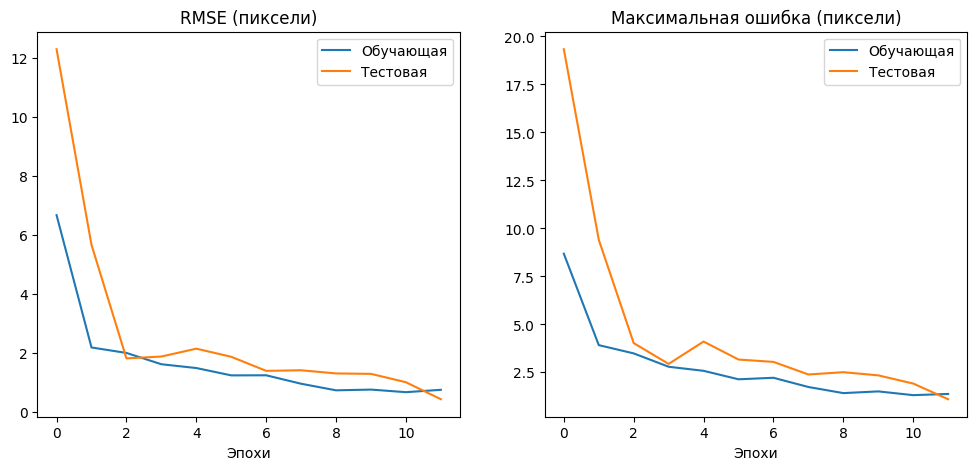

In [9]:
# Оценка на тестовом наборе
test_loss, test_rmse, test_max_error = model.evaluate(test_ds, verbose=0)
print(f"\nОшибки на тестовом наборе:")
print(f"RMSE: {test_rmse:.2f} пикселей")
print(f"Максимальная ошибка: {test_max_error:.2f} пикселей")

# Визуализация обучения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['rmse'], label='Обучающая')
plt.plot(history.history['val_rmse'], label='Тестовая')
plt.title('RMSE (пиксели)')
plt.xlabel('Эпохи')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['max_error'], label='Обучающая')
plt.plot(history.history['val_max_error'], label='Тестовая')
plt.title('Максимальная ошибка (пиксели)')
plt.xlabel('Эпохи')
plt.legend()
plt.show()

# Предсказание на случайном изображении из датасета

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


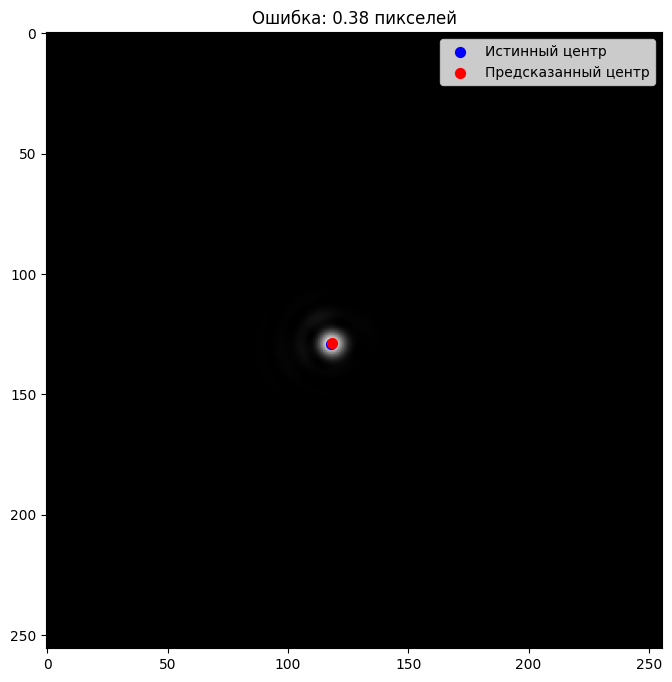

In [10]:
import random

# Тестовый датасет в виде списка
test_images = list(test_ds.unbatch().as_numpy_iterator())

# Выбираем случайное изображение
random_sample = random.choice(test_images)
sample_image = random_sample[0][np.newaxis, ...]  # Добавляем batch-размерность
true_center = random_sample[1][np.newaxis, ...]  # Добавляем batch-размерность

# Получаем предсказание
predicted_center = model.predict(sample_image)[0]

# Отображение результата
plt.figure(figsize=(8, 8))
plt.imshow(sample_image[0].squeeze(), cmap='gray')
plt.scatter(true_center[0][1], true_center[0][0], c='blue', s=50, label='Истинный центр')
plt.scatter(predicted_center[1], predicted_center[0], c='red', s=50, label='Предсказанный центр')
plt.title(f"Ошибка: {np.linalg.norm(true_center[0] - predicted_center):.2f} пикселей")
plt.legend()
plt.show()

# Сохранение модели

In [ ]:
#model_path = '/content/drive/My Drive/Colab_Notebooks/psf_center_model.h5'
#model.save(model_path)

# Сохранение истории обучения
#import pickle
#history_path = '/content/drive/My Drive/Colab_Notebooks/history.pkl'
#with open(history_path, 'wb') as f:
#    pickle.dump(history.history, f)